# Installs

In [21]:
%pip install datasets[vision]
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt  # install

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Cloning into 'yolov5'...
remote: Enumerating objects: 13966, done.
remote: Counting objects: 100% (142/142), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 13966 (delta 92), reused 89 (delta 62), pack-reused 13824
Receiving objects: 100% (13966/13966), 13.52 MiB | 17.30 MiB/s, done.
Resolving deltas: 100% (9567/9567), done.
/content/yolov5/yolov5


# Imports

In [22]:
import datasets
import torch
import utils
import numpy as np
from tqdm.notebook import tqdm, trange
import os
from google.colab import files
import matplotlib.pyplot as plt
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode

In [23]:
display = utils.notebook_init()

YOLOv5 🚀 v6.2-263-g0307954 Python-3.7.15 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 31.4/78.2 GB disk)


# Global constants

In [24]:
# only used for debugging
# N_TRAIN_SAMPLES = 800
# N_VAL_SAMPLES = 200

# Functions

In [25]:
def coco_to_yolo(bbox, h, w):
    x_center = (bbox[0] + bbox[2] / 2) / w
    y_center = (bbox[1] + bbox[3] / 2) / h
    return [x_center, y_center, bbox[2] / w, bbox[3] / h]

In [26]:
def coco_to_yolo_multiple(bboxes, h, w):
    new_bboxes = []
    for bbox in bboxes:
        new_bboxes.append(coco_to_yolo(bbox, h, w))
    return new_bboxes

In [27]:
def add_bbox(example):
    image = np.array(example["image"])
    h = image.shape[0]
    w = image.shape[1]
    example["faces"] = coco_to_yolo_multiple(example["faces"]["bbox"], h, w)
    return example

In [28]:
def create_yaml():
    with open("data/faces.yaml", 'w+') as f:
        f.write("path: data/faces\n")
        f.write("train: train\n")
        f.write("val: val\n\n")
        f.write("names:\n")
        f.write("  0: face\n")

In [29]:
def write_label(name, bboxes, split):
    path = f'data/faces/{split}/{name}.txt'
    with open(path, 'w+') as f:
        for bbox in bboxes:
            line = '0 '
            for i in range(4):
                line += f'{bbox[i]} '
            line += '\n'
            f.write(line)

In [30]:
def save_image(name, image, split):
    image.save(f"data/faces/{split}/{name}.jpg")

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

# Setup data

## Load and split data

In [31]:
ds_train = datasets.load_dataset("wider_face", split="train")
ds_val = datasets.load_dataset("wider_face", split="validation")

In [32]:
ds_train = ds_train.map(add_bbox)
ds_val = ds_val.map(add_bbox)
ds_train = ds_train.rename_column('faces', 'bboxes')
ds_val = ds_val.rename_column('faces', 'bboxes')

In [33]:
# debugging datasets
# ds = datasets.load_dataset("wider_face", split="validation")
# ds.shuffle()
# ds_subset = ds.select(range(N_TRAIN_SAMPLES + N_VAL_SAMPLES))
# ds_subset = ds_subset.map(add_bbox)
# ds_subset = ds_subset.rename_column('faces', 'bboxes')
# ds_train = ds_subset.select(range(0, N_TRAIN_SAMPLES))
# ds_val = ds_subset.select(range(N_TRAIN_SAMPLES, N_TRAIN_SAMPLES + N_VAL_SAMPLES))

## Process data

In [34]:
# create directories for training and val images / labels
%mkdir data/faces
%mkdir data/faces/train
%mkdir data/faces/val

In [35]:
create_yaml()

In [36]:
# save the images and labels
for ds, split in zip([ds_train, ds_val], ['train', 'val']):
    for i in trange(len(ds)):
        write_label(i, ds[i]['bboxes'], split)
        save_image(i, ds[i]['image'], split)

0it [00:00, ?it/s]

  0%|          | 0/12880 [00:00<?, ?it/s]

  0%|          | 0/3226 [00:00<?, ?it/s]

# Train

In [39]:
!python train.py --img 640 --batch 16 --epochs 3 --data faces.yaml --weights yolov5s.pt --cache

train: weights=yolov5s.pt, cfg=, data=faces.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=3, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.2-263-g0307954 Python-3.7.15 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, deg

In [41]:
model_path = 'runs/train/'
experiment = os.listdir(model_path)[-1]
model_path = os.path.join(model_path, experiment, 'weights/best.pt')
files.download(model_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Detect

<IPython.core.display.Javascript object>

Saved to photo.jpg


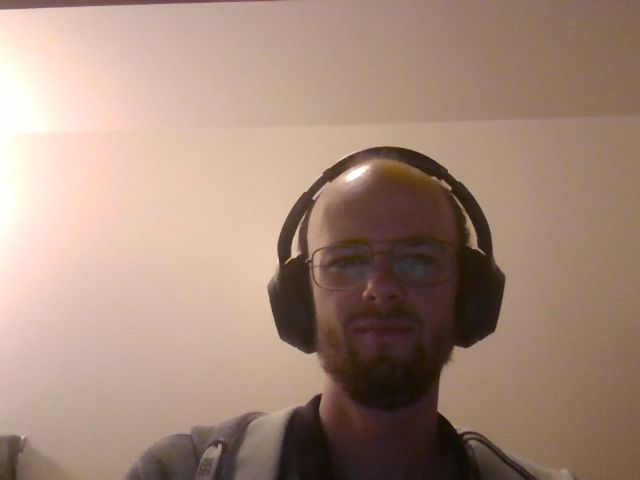

In [50]:
# take webcam foto
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [47]:
!python detect.py --weights runs/train/exp/weights/best.pt --img 640 --conf 0.25 --source photo.jpg

detect: weights=['runs/train/exp/weights/best.pt'], source=photo.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v6.2-263-g0307954 Python-3.7.15 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/1 /content/yolov5/yolov5/photo.jpg: 480x640 1 face, 11.2ms
Speed: 0.5ms pre-process, 11.2ms inference, 4.8ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp4


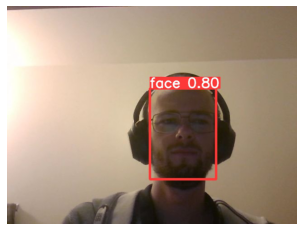

In [51]:
im = plt.imread("runs/detect/exp4/photo.jpg")
plt.axis('off')
plt.imshow(im)
plt.show()